In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import warnings
warnings.simplefilter(action='ignore')
import seaborn as sns
import statsmodels.api as sm
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

### Reading all data 

In [2]:
train_data = pd.read_csv('train.csv')
item_data = pd.read_csv('item_data.csv')
view_log = pd.read_csv('view_log.csv')
test_data = pd.read_csv('test.csv')

extracting basic information from data

In [3]:
def unique_num(data, key):
    return len(set(data[key]))
## day of the week and time of day
def add_feature( data, time_key):
    data['day'] = [int(x.split(' ')[0].split('-')[2])%7 for x in  data[time_key]]
    data['hour'] = [float(x.split(' ')[1].split(':')[0]) for x in data[time_key]]
    return data

In [4]:
display(train_data.head(2))
n_click_train = len(train_data[train_data['is_click']==1])
n_noclick_train = len(train_data[train_data['is_click']==0])
print ('Number of unique users :- %s'%(len(np.unique(train_data['user_id']))))
print ('Number of clicks :- %s'%(n_click_train))
print ('Number of no click :- %s'%(n_noclick_train))
print ('----> Percentage of clicks to noclick in train data :- %f'%(n_click_train*100/n_noclick_train))
print ('---------------------------------')
print ('---------------------------------')

chars = [ch for ch in train_data['impression_id'][0] ]
print ('Length of impression id characters %s is same as length of data'%(len (chars)))
print (unique_num(train_data, 'impression_id'))
print ('----> each impression id encodes entire information of user_id, impression time, os version, is_4G and clicking data')


time_key = ['impression_time', 'server_time']
train_data = add_feature(train_data, time_key[0])
test_data = add_feature(test_data, time_key[0])
view_log = add_feature(view_log, time_key[1])

#print (unique_num(train_data, 'impression_time_int'))
train_data['os_version_num'] = np.zeros(len(train_data))
train_data['os_version_num'][train_data['os_version'] == 'intermediate'] = int(2)
train_data['os_version_num'][train_data['os_version'] == 'old'] = int(1)
train_data['os_version_num'][train_data['os_version'] == 'latest'] = int(3)
display(train_data.head(2))

,impression_id,impression_time,user_id,app_code,os_version,is_4G,is_click
0,c4ca4238a0b923820dcc509a6f75849b,2018-11-15 00:00:00,87862,422,old,0,0
1,45c48cce2e2d7fbdea1afc51c7c6ad26,2018-11-15 00:01:00,63410,467,latest,1,1


Number of unique users :- 74723
Number of clicks :- 10862
Number of no click :- 226747
----> Percentage of clicks to noclick in train data :- 4.790361
---------------------------------
---------------------------------
Length of impression id characters 32 is same as length of data
237609
----> each impression id encodes entire information of user_id, impression time, os version, is_4G and clicking data


,impression_id,impression_time,user_id,app_code,os_version,is_4G,is_click,day,hour,os_version_num
0,c4ca4238a0b923820dcc509a6f75849b,2018-11-15 00:00:00,87862,422,old,0,0,1,0.0,1.0
1,45c48cce2e2d7fbdea1afc51c7c6ad26,2018-11-15 00:01:00,63410,467,latest,1,1,1,0.0,3.0


So, only 4.8% of all impressions result in a click

In [5]:
## identifying the features for modeling
df = pd.DataFrame(train_data)
x_y = df.drop('impression_id',  1)
x_y = x_y.drop ('impression_time', 1)
print (x_y.columns)
plt.show()
display(x_y.head(2))

Index(['user_id', 'app_code', 'os_version', 'is_4G', 'is_click', 'day', 'hour',
       'os_version_num'],
      dtype='object')


,user_id,app_code,os_version,is_4G,is_click,day,hour,os_version_num
0,87862,422,old,0,0,1,0.0,1.0
1,63410,467,latest,1,1,1,0.0,3.0


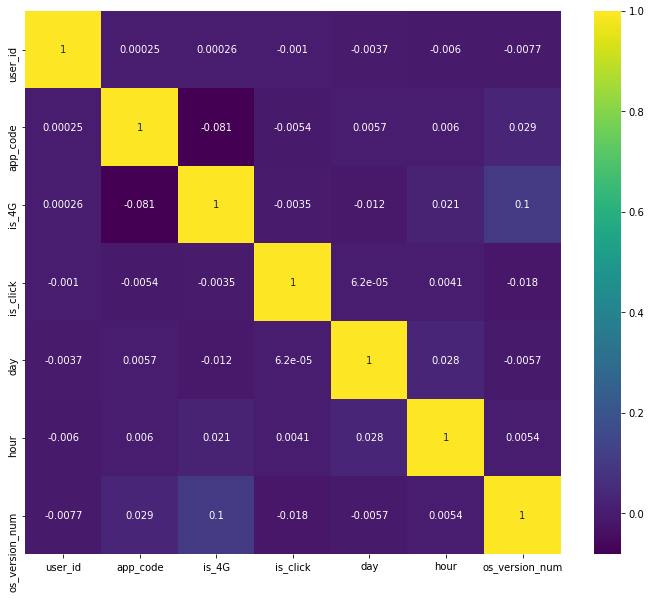

In [6]:
plt.figure(figsize=(12,10))
cor = x_y.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.viridis)
plt.show()

In [7]:
#Correlation with output variable
cor_target = abs(cor["is_click"])
#Selecting highly correlated features
relevant_features = cor_target[cor_target>0.001]
print (relevant_features)
print ('=============')
print (x_y[['os_version_num', 'is_4G']].corr())
print ('os version and is_4G are correlated makes sense because normally latest version are more likely to have 4G connection')


print ('==========================')
print (x_y[['os_version_num', 'app_code']].corr() )
print (x_y[['app_code', 'hour']].corr() )
print (x_y[['os_version_num', 'hour']].corr() )


print ('None of these features are correlated with each other,\
\nTherefore I believe the relevant features for traning should be :- ', 'app_code', 'hour', 'os_version_int' )
print ('we can get rid of 2 features user_id, and is_4G.... may be more testin required before gettin rid of these')

user_id           0.001035
app_code          0.005449
is_4G             0.003464
is_click          1.000000
hour              0.004081
os_version_num    0.017669
Name: is_click, dtype: float64
                os_version_num     is_4G
os_version_num        1.000000  0.101101
is_4G                 0.101101  1.000000
os version and is_4G are correlated makes sense because normally latest version are more likely to have 4G connection
                os_version_num  app_code
os_version_num        1.000000  0.028788
app_code              0.028788  1.000000
          app_code      hour
app_code  1.000000  0.005997
hour      0.005997  1.000000
                os_version_num      hour
os_version_num        1.000000  0.005387
hour                  0.005387  1.000000
None of these features are correlated with each other,
Therefore I believe the relevant features for traning should be :-  app_code hour os_version_int
we can get rid of 2 features user_id, and is_4G.... may be more testin required b

In [8]:
### AN attempt to understand user profiles using view_log
import warnings
warnings.filterwarnings('ignore')

display(view_log.head(2))

print ('=======================')
unique_devices = np.unique(view_log['device_type'])
for i in range(3):  
    print (len(view_log[view_log['device_type'] == unique_devices[i]]), '%s users'%(unique_devices[i]))
print ('=======================')



,server_time,device_type,session_id,user_id,item_id,day,hour
0,2018-10-15 08:58:00,android,112333,4557,32970,1,8.0
1,2018-10-15 08:58:00,android,503590,74788,7640,1,8.0


3117737 android users
861 iphone users
24 web users


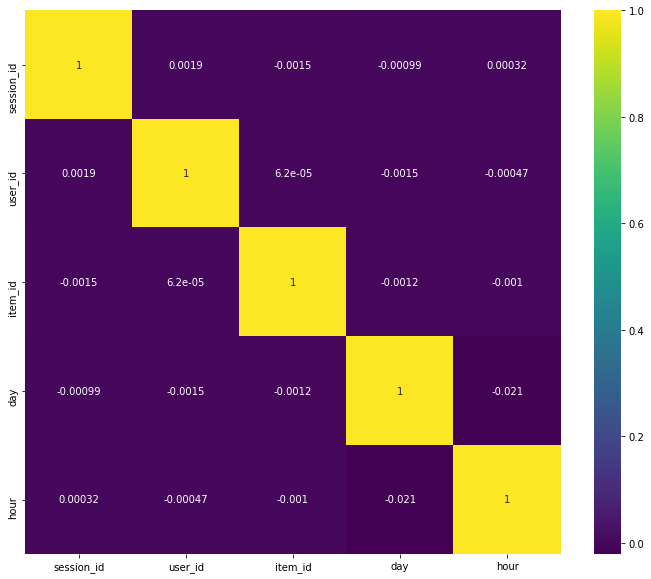

In [9]:
df_view = pd.DataFrame(view_log)
df_view = df_view.drop('server_time',1)
plt.figure(figsize=(12,10))
cor = df_view.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.viridis)
plt.show()

,item_id,item_price,category_1,category_2,category_3,product_type
0,26880,4602,11,35,20,3040
1,54939,3513,12,57,85,6822


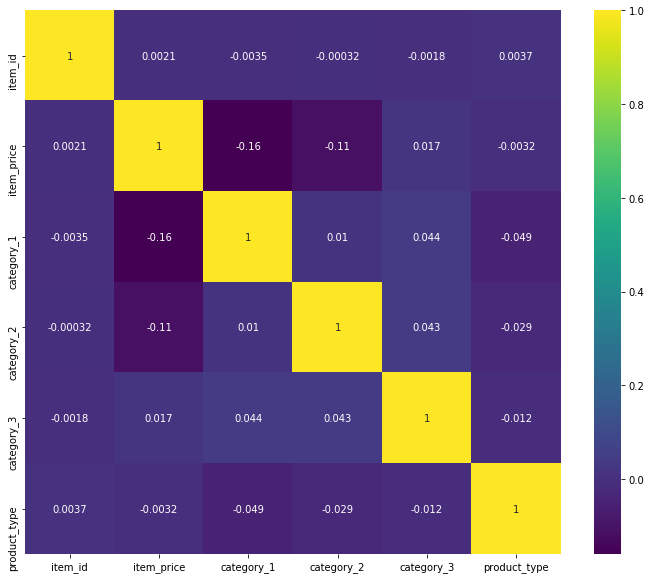

In [10]:
display(item_data.head(2))
df_item = pd.DataFrame(item_data)
plt.figure(figsize=(12,10))
cor = df_item.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.viridis)
plt.show()

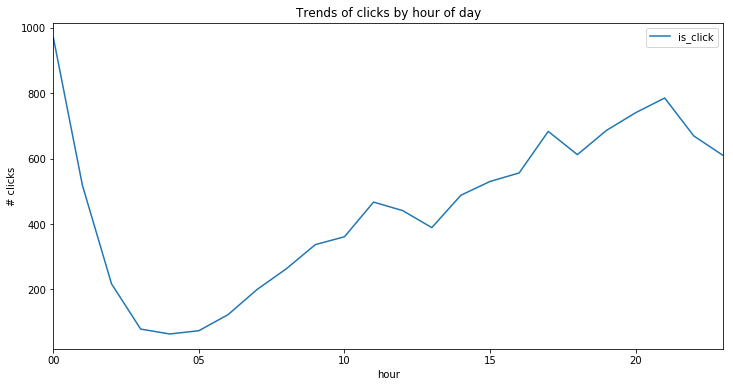

In [11]:
train_data['hour'] = train_data.impression_time.apply(lambda x: x.split(" ")[1].split(':')[0])
train_data.groupby('hour').agg({'is_click':'sum'}).plot(figsize=(12,6))
plt.ylabel('# clicks')
plt.title('Trends of clicks by hour of day');

In [12]:
#display(train_data.head())
train = train_data

In [13]:
#print (unique_num(train_data, 'impression_time_int'))
test_data['os_version_num'] = np.zeros(len(test_data))
test_data['os_version_num'][test_data['os_version'] == 'intermediate'] = int(2)
test_data['os_version_num'][test_data['os_version'] == 'old'] = int(1)
test_data['os_version_num'][test_data['os_version'] == 'latest'] = int(3)

# xgboost 

In [16]:
print('XGBoost Model')

features = [ 'user_id', 'app_code', 'is_4G', 'day', 'os_version_num']

params = {
        "objective": "binary:logistic",
        "booster" : "gbtree",
        "eval_metric": "auc",
        "eta": 0.1,
        "max_depth": 5,
        "subsample": 0.8,
        "colsample_bytree": 1,
        "silent": 0,
        "seed": 0
    }

X_train, X_valid = train_test_split(train, test_size=0.2, random_state=0)
y_train = X_train['is_click']
y_valid = X_valid['is_click']

dtrain = xgb.DMatrix(X_train[features], y_train)
dvalid = xgb.DMatrix(X_valid[features], y_valid)
watchlist = [(dtrain, 'train'), (dvalid, 'eval')]

xgb_out = xgb.train(params, dtrain, num_boost_round = 260, evals=watchlist,early_stopping_rounds=20, verbose_eval=True)


XGBoost Model
[0]	train-auc:0.668103	eval-auc:0.666355
Multiple eval metrics have been passed: 'eval-auc' will be used for early stopping.

Will train until eval-auc hasn't improved in 20 rounds.
[1]	train-auc:0.672919	eval-auc:0.669035
[2]	train-auc:0.674384	eval-auc:0.668875
[3]	train-auc:0.675157	eval-auc:0.669813
[4]	train-auc:0.675585	eval-auc:0.670488
[5]	train-auc:0.675864	eval-auc:0.670344
[6]	train-auc:0.676584	eval-auc:0.671581
[7]	train-auc:0.676922	eval-auc:0.671444
[8]	train-auc:0.681403	eval-auc:0.675838
[9]	train-auc:0.682711	eval-auc:0.67774
[10]	train-auc:0.684697	eval-auc:0.680863
[11]	train-auc:0.685809	eval-auc:0.681075
[12]	train-auc:0.685682	eval-auc:0.680451
[13]	train-auc:0.685592	eval-auc:0.680645
[14]	train-auc:0.685938	eval-auc:0.681015
[15]	train-auc:0.686632	eval-auc:0.681433
[16]	train-auc:0.687463	eval-auc:0.682475
[17]	train-auc:0.68766	eval-auc:0.682726
[18]	train-auc:0.687818	eval-auc:0.682667
[19]	train-auc:0.688125	eval-auc:0.683073
[20]	train-auc:0.

[191]	train-auc:0.752171	eval-auc:0.699026
[192]	train-auc:0.752325	eval-auc:0.698955
[193]	train-auc:0.752493	eval-auc:0.699205
[194]	train-auc:0.752634	eval-auc:0.699359
[195]	train-auc:0.752858	eval-auc:0.699229
[196]	train-auc:0.753145	eval-auc:0.699153
[197]	train-auc:0.753392	eval-auc:0.699252
[198]	train-auc:0.753465	eval-auc:0.699183
[199]	train-auc:0.753743	eval-auc:0.699239
[200]	train-auc:0.754247	eval-auc:0.699361
[201]	train-auc:0.75486	eval-auc:0.69948
[202]	train-auc:0.754957	eval-auc:0.699596
[203]	train-auc:0.755146	eval-auc:0.699576
[204]	train-auc:0.755449	eval-auc:0.69981
[205]	train-auc:0.755425	eval-auc:0.699694
[206]	train-auc:0.755536	eval-auc:0.699665
[207]	train-auc:0.755747	eval-auc:0.699646
[208]	train-auc:0.756136	eval-auc:0.699649
[209]	train-auc:0.756275	eval-auc:0.699712
[210]	train-auc:0.756649	eval-auc:0.699952
[211]	train-auc:0.757139	eval-auc:0.699963
[212]	train-auc:0.757434	eval-auc:0.699932
[213]	train-auc:0.757868	eval-auc:0.699682
[214]	train-au

In [17]:
predictions_xgboost = xgb_out.predict(xgb.DMatrix(test_data.drop(['impression_time', 'os_version', 'impression_id', 'hour'], axis =1)))

In [18]:
submission = pd.read_csv("sample_submission.csv")

In [19]:
predict = pd.DataFrame(data=predictions_xgboost, columns=["is_click"])
seg_pd = pd.DataFrame(data=submission, columns=["impression_id"])
submission = pd.concat([seg_pd, predict], axis=1)
submission.to_csv("submission.csv", index=False)
submission.head(10)

,impression_id,is_click
0,a9e7126a585a69a32bc7414e9d0c0ada,0.065508
1,caac14a5bf2ba283db7708bb34855760,0.011253
2,13f10ba306a19ce7bec2f3cae507b698,0.066314
3,39c4b4dc0e9701b55a0a4f072008fb3f,0.013571
4,bf5a572cca75f5fc67f4b14e58b11d70,0.081898
5,ca09514449e304fee91456fb0918667a,0.012114
6,b8b35cb0ae1719aa9f0ba7a9f3785687,0.115585
7,33502d1e85818b9b3414c8c006c34e07,0.020505
8,5314e09fb680c56b58eb5a3b5b7bce0c,0.084961
9,e1a8a26385f49a5a7e04d34a5823bff3,0.012221
